In [10]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [91]:
# dark mode for matplotlib
plt.style.use('dark_background')


In [66]:
kilometers_offshore = 100
upper_windspeed = 12
lower_windspeed = 9

In [87]:
brazil = gpd.read_file('data/brazil.geojson')
polygon = max(brazil.geometry[0].geoms, key=lambda x: x.area)
offshore = gpd.GeoDataFrame({'geometry': [polygon]}, crs=brazil.crs) \
    .to_crs('EPSG:5880') \
    .buffer(kilometers_offshore * 1000) \
    .to_crs(brazil.crs) \
    .difference(brazil)

offshore.to_file('data/offshore.geojson', driver='GeoJSON')
offshore.union(brazil).to_file('data/offshore_brazil.geojson', driver='GeoJSON')


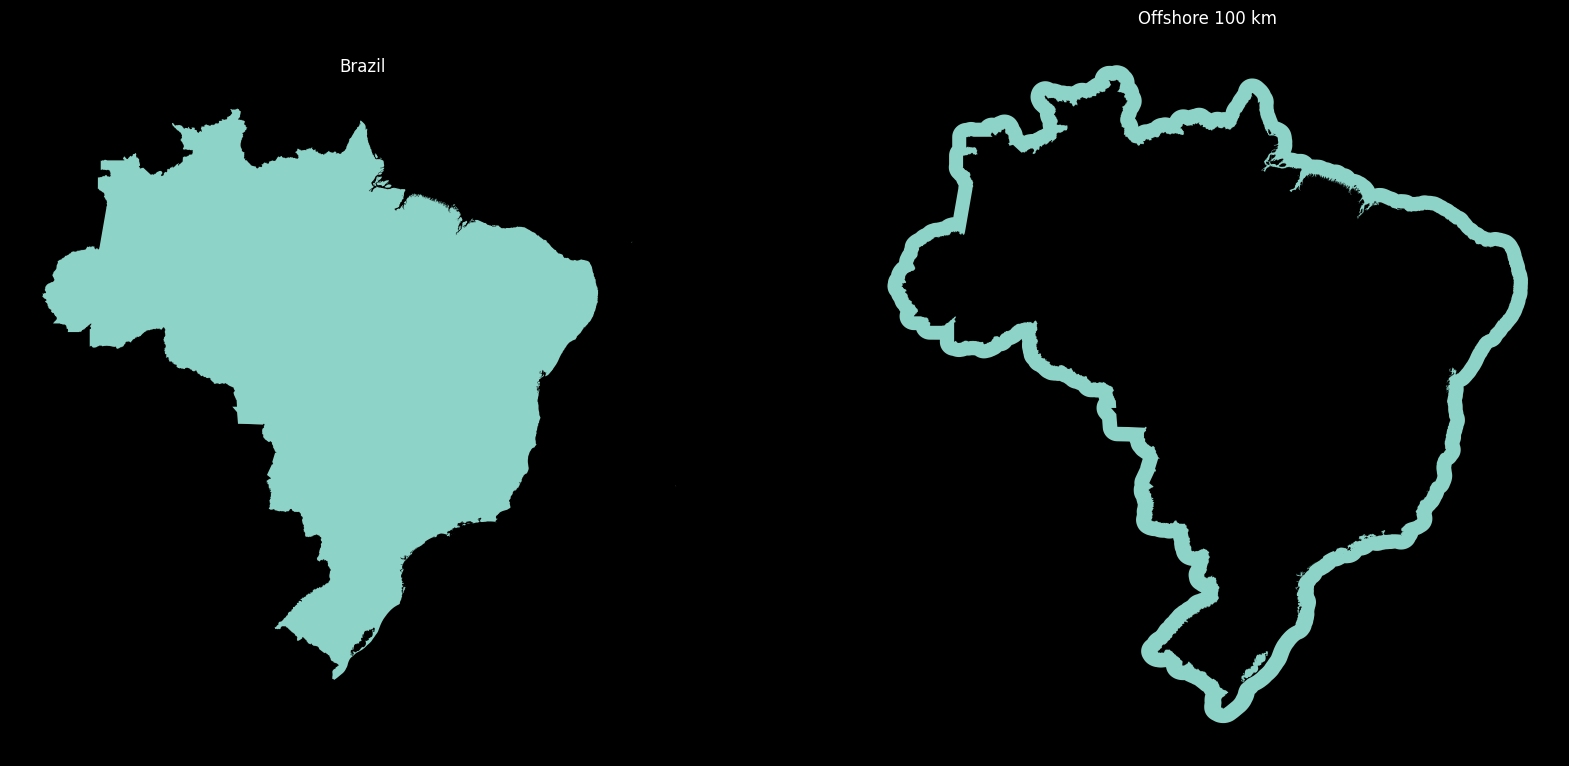

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
brazil.plot(ax=axes[0])
axes[0].set_title('Brazil')
axes[0].set_axis_off()
offshore.plot(ax=axes[1])
axes[1].set_title(f'Offshore {kilometers_offshore} km')
axes[1].set_axis_off()
plt.show()

In [97]:
brazil_and_offshore = offshore.union(brazil)

with rasterio.open('data/gwa3_250_powerdensity_100m.tif') as src:
    power_density = src.read(1, window=brazil_and_offshore.total_bounds) if not 'power_density' in locals() else eval('power_density')

with rasterio.open('data/gwa3_250_windspeed_100m.tif') as src:
    wind_speed = src.read(1, window=brazil_and_offshore.total_bounds) if not 'wind_speed' in locals() else eval('wind_speed')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

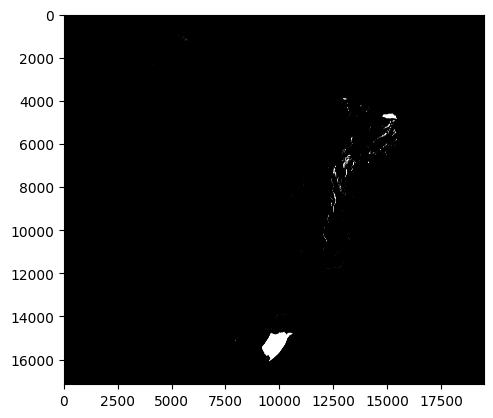

In [33]:
mask = (wind_speed > lower_windspeed) & (wind_speed < upper_windspeed)
plt.imshow(mask, cmap='gray')

<Axes: >

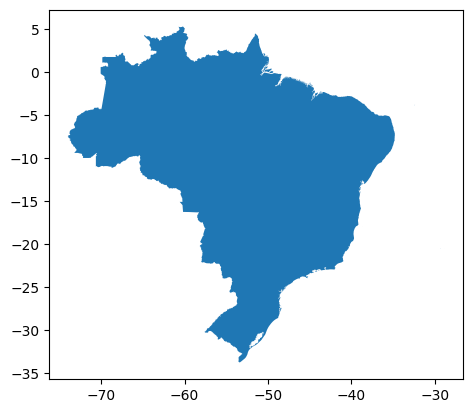

In [46]:
brazil.plot()

<Axes: >

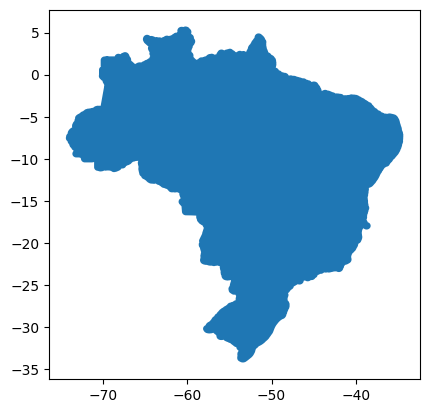

In [90]:
brazil_offshore_single.plot()

In [52]:
brazil_offshore.head()

,geometry
0,"MULTIPOLYGON (((-29.67630 -20.19222, -29.67226..."
